<h1 style = "color:green" align = "right"> Depression Mood Tracker </h1>

<img src="images/depression_sit.png" alt="Drawing"/>

# Concept study

The goal of this project is to **assess depression** in patients by analyzing **personal and lifestyle factors**. 

<h3>Depression Detection Dataset</h3>

<p>This <a href="https://www.kaggle.com/datasets/anthonytherrien/depression-dataset">dataset</a> contains information on individuals with various attributes related to their personal and lifestyle factors. It is designed to facilitate analysis in areas such as health, lifestyle, and socio-economic status.</p>


<h3>Features Description:</h3>
<ul>
    <li><strong>Name</strong>: The full name of the individual [Text]</li>
    <li><strong>Age</strong>: The age of the individual [years: Numeric]</li>
    <li><strong>Marital Status</strong>: The marital status of the individual 
        [Single, Married, Divorced, Widowed]</li>
    <li><strong>Education Level</strong>: The highest level of education attained by the individual 
        [High School, Associate Degree, Bachelor's Degree, Master's Degree, PhD]</li>
    <li><strong>Number of Children</strong>: The number of children the individual has [Numeric]</li>
    <li><strong>Smoking Status</strong>: Indicates whether the individual is a smoker or not 
        [Smoker, Former, Non-smoker]</li>
    <li><strong>Physical Activity Level</strong>: The level of physical activity undertaken by the individual 
        [Sedentary, Moderate, Active]</li>
    <li><strong>Employment Status</strong>: The employment status of the individual 
        [Employed, Unemployed]</li>
    <li><strong>Income</strong>: The annual income of the individual [USD: Numeric]</li>
    <li><strong>Alcohol Consumption</strong>: The level of alcohol consumption 
        [Low, Moderate, High]</li>
    <li><strong>Dietary Habits</strong>: The dietary habits of the individual 
        [Healthy, Moderate, Unhealthy]</li>
    <li><strong>Sleep Patterns</strong>: The quality of sleep 
        [Good, Fair, Poor]</li>
    <li><strong>History of Mental Illness</strong>: Whether the individual has a history of mental illness 
        [Yes, No]</li>
    <li><strong>History of Substance Abuse</strong>: Whether the individual has a history of substance abuse 
        [Yes, No]</li>
    <li><strong>Family History of Depression</strong>: Indicates if there is a family history of depression 
        [Yes, No]</li>
    <li><strong>Chronic Medical Conditions</strong>: Whether the individual has chronic medical conditions 
        [Yes, No]</li>
</ul>

#### 📝 **Important Note**

For this project, we considered **chronic medical conditions** as the **target variable** because it is the only variable that reflects the current health status of patients. Given that **depression is a chronic illness** with long-term impacts on mental and physical health, this variable plays a critical role in understanding the condition and its progression.

##### 📚 **Why is Depression Considered a Chronic Illness?**

1. **Depression's Long-Term Effects**: Chronic depression often lasts for years, with recurrent episodes and a significant impact on quality of life.  
   *Source*: [National Institute of Mental Health (NIMH)](https://www.nimh.nih.gov/health/publications/depression)

2. **Classification as a Chronic Condition**: Depression is classified as a chronic disease due to its persistence and the need for ongoing treatment.  
   *Source*: [World Health Organization (WHO)](https://www.who.int/news-room/fact-sheets/detail/depression)

3. **Understanding Chronic Depression**: An article discussing the relationship between chronic diseases and depression, highlighting the importance of addressing both for effective treatment.  
   *Source*: [PubMed Central](https://pmc.ncbi.nlm.nih.gov/articles/PMC1071593/)

---

💡 **NB**: Understanding depression as a chronic illness is essential to building effective predictive models and designing interventions for improved mental health care. 


<h3>Usage:</h3>
<p>This dataset is suitable for tasks such as predictive modeling, clustering, and exploratory data analysis. It provides valuable insights for understanding the relationships between personal and lifestyle factors and mental health outcomes, specifically focusing on depression detection and prevention.</p>

Data sourced from: <a href="https://www.kaggle.com/datasets/anthonytherrien/depression-dataset">Kaggle Depression Dataset</a>.


**Reminder:**

In this project, we will use information about patient to predict if they have some **chronic medical conditions** or if they are **depressive**.

### **Disclaimer** 🛑  
The dataset used in this project is **synthetic** and has been generated rather than collected from real-world sources. ⚠️ Due to the lack of transparency in the data synthesis process, the exact methods and criteria used are **unknown** 🤷‍♂️. As a result, the patterns and relationships within the data may not accurately reflect real-world phenomena 🌍.  

🔍 **Key Points to Note:**  
1️⃣ The results and insights from this dataset should be interpreted with **caution** 🚧.  
2️⃣ These findings are **not reliable** for making real-world decisions or predictions 🚫.  
3️⃣ This project is intended solely for **educational** and **experimental** purposes 🧪📚.  

---

##### **Supporting Sources** 📚  
Here are some resources explaining the limitations and considerations of synthetic data:  

- 🎲 **The Benefits and Limitations of Generating Synthetic Data** - [Syntheticus](https://syntheticus.ai/blog/the-benefits-and-limitations-of-generating-synthetic-data?utm_source=chatgpt.com)  
- 🩺 **Harnessing the Power of Synthetic Data in Healthcare** - [Nature](https://www.nature.com/articles/s41746-023-00927-3?utm_source=chatgpt.com)  
- ⚖️ **Synthetic Health Data: Real Ethical Promise and Peril** - [PMC](https://pmc.ncbi.nlm.nih.gov/articles/PMC11555762/?utm_source=chatgpt.com)  
- 🔗 **The Pros and Cons of Synthetic Data** - [DATAVERSITY](https://www.dataversity.net/the-pros-and-cons-of-synthetic-data/?utm_source=chatgpt.com)  
- 💡 **The Dangers of Using Synthetic Patient Data to Build Healthcare AI Models** - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2023/05/26/the-dangers-of-using-synthetic-patient-data-to-build-healthcare-ai-models/?utm_source=chatgpt.com)  
- 🧠 **Synthetic Data Generation with Large Language Models: Potential and Limitations** - [arXiv](https://arxiv.org/abs/2310.07849?utm_source=chatgpt.com)  
- 📊 **Reimagining Synthetic Tabular Data Generation Through Data-Centric AI** - [arXiv](https://arxiv.org/abs/2310.16981?utm_source=chatgpt.com)  

---

# Necessary setup

Note that this project has been realised under `python 3.11` as **capstone project** for the **2024 ML Zoomcamp**.

## Install

Let's install `kaggle` to be able to download datasets from Kaggle.

In [1]:
# install kaggle library
!pip install kaggle

To use the command line interface, `'Kaggle CLI tool'`, we had to set up our **API keys**. 

For this, we went to the `'Account'` tab of our user profile on Kaggle, and selected `'Create New Token'`. This triggered the download of `kaggle.json`, a file containing our *API credentials*. We then made sure that the token was saved at *~/.kaggle/kaggle.json*, as we are working on `Ubuntu` (WSL distribution). It is the same address to verify for Linux, OSX, and other UNIX-based operating systems. For Windows, check *C:\Users\<Windows-username>\.kaggle\kaggle.json* instead. If the token is not there, an error will be raised. Hence, once downloaded the token, it should be moved to this folder.

## Import

In [2]:
# Necessary import
import pickle # to manipulate models
import zipfile # to manipulate .zip file
import numpy as np # for matrices and numerical manipulations
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plots
import seaborn as sns # for visualizing data

from sklearn.metrics import mutual_info_score # for feature importance
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding
from sklearn.model_selection import train_test_split, KFold # for cross-validation techniques
from sklearn.linear_model import LogisticRegression # for logistic regression model
from sklearn.tree import DecisionTreeClassifier # for decision trees

In [3]:
# Import only to get versions
import sys # for the system
import matplotlib, sklearn # for visualization and modelisation library

In [4]:
# System versions
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---" * 47)

# Libraries versions
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)

Platform: linux
Python version: 3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
---------------------------------------------------------------------------------------------------------------------------------------------
matplotlib version: 3.9.2
seaborn version: 0.13.2
sklearn version: 1.5.1
pandas version: 2.2.2
numpy version: 1.26.4


# Data Sourcing

Let's download the [dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset) using the command line interface (`CLI`):

In [5]:
# download the data
!kaggle datasets download anthonytherrien/depression-dataset

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/depression-dataset
License(s): CC-BY-SA-4.0
100%|██████████████████████████████████████| 8.69M/8.69M [02:16<00:00, 42.0kB/s]
100%|██████████████████████████████████████| 8.69M/8.69M [02:16<00:00, 66.9kB/s]


In [6]:
# list files in current directory
!ls

LICENSE    capstone_project_01.ipynb  depression-dataset.zip
README.md  data			      images


A .zip file (`depression-dataset.zip`) containing the dataset has been downloaded. We will extract the data and store it into the `data` folder.

In [7]:
# Unzip the `depression-dataset.zip` file
with zipfile.ZipFile("depression-dataset.zip", "r") as depression_data:
    depression_data.extractall("data") # extract all files to the data directory

In [8]:
# list files in the folder `data`
!ls data

depression_data.csv


We can see that there is now a new .csv file: `depression_data.csv`, in the `data` directory.

Let's visualize its first lines:

In [9]:
# dataset first rows
!head data/depression_data.csv

Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
Kathy Hill,20,Single,High School,0,Former,Active,Employed,44448.91,Low,Unhealthy,Fair,No,Yes,No,No
Crystal Delgado,60,Widowed,Associat

We can now read the dataset as a dataframe:

In [10]:
# Read the dataframe
df = pd.read_csv("data/depression_data.csv")

# Three last rows
df.tail(3)

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No
413767,Joseph Johnson,62,Widowed,Master's Degree,0,Former,Moderate,Employed,107125.74,Moderate,Healthy,Good,No,Yes,No,No


# Exporatory Data Analysis & Data Preparation

Let's get more information about the dataset:

In [11]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [12]:
# Check missing values
df.isna().sum()

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

In [13]:
# Check of duplicated rows
df.duplicated().sum()

0

The dataset does not have any missing values, and duplicated rows.

We can rename the variable names to uniformize them.

In [14]:
# Normalisation of column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
# Dataset column names
df.columns

Index(['name', 'age', 'marital_status', 'education_level',
       'number_of_children', 'smoking_status', 'physical_activity_level',
       'employment_status', 'income', 'alcohol_consumption', 'dietary_habits',
       'sleep_patterns', 'history_of_mental_illness',
       'history_of_substance_abuse', 'family_history_of_depression',
       'chronic_medical_conditions'],
      dtype='object')

The column `name` has private information that will not be used for training our models and that we would prefere to disclose.

In [15]:
# drop patient names
df.drop(columns = "name", inplace = True)

## Target Variable Analysis

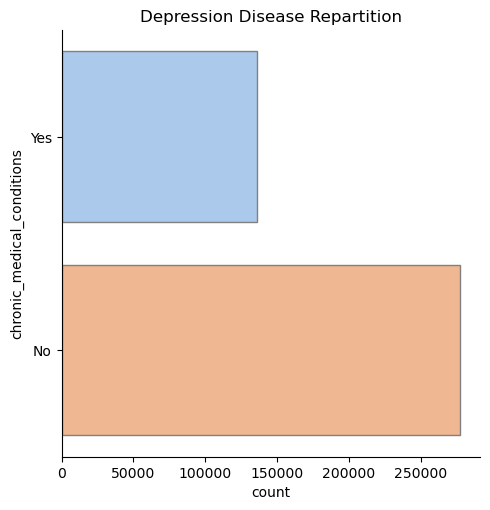

In [16]:
# Target variable distribution
sns.catplot(df, y = "chronic_medical_conditions", kind = "count",
            hue = "chronic_medical_conditions",
            palette = "pastel",
            edgecolor = ".5")
# Title
plt.title('Depression Disease Repartition');

The data distribution for the target variable is highly unbalanced. There are many options to fix this issue:

- Balancing the data: either with downsampling, oversampling, or a method mixing both techniques.
- Using a metric that is suitable for unbalanced data such as the **AUC score**, or the **F1 score**.

In this project, as the dataset is quite huge, we will perform a **down-sampling technique** to under-sample the majority class (`No`) so it reaches the minority one (`Yes`). We will perform this down-sampling with the `sample()` pandas method and `random_state` of `37` for reproducibility.

In [17]:
# Get the minority class size
down_size = len(df[df.chronic_medical_conditions == "Yes"])
down_size # output this size

136207

In [18]:
# Get a down-sampled subset of the majority class
df_maj_class = df[df.chronic_medical_conditions == "No"].sample(n = down_size, random_state = 37)

# Build the balanced dataset
bal_df = pd.concat([df_maj_class, # majority class
                    df[df.chronic_medical_conditions == "Yes"] # minority class
                   ])
# Let's shuffle the data-set
bal_df = bal_df.sample(frac = 1, random_state = 1).reset_index(drop = True)

# Data shape
print(f"Data Shape: {bal_df.shape[0]} rows and {bal_df.shape[1]} columns.", "---"*47)
# First elements of the resampled
bal_df.head(3)

Data Shape: 272414 rows and 15 columns. ---------------------------------------------------------------------------------------------------------------------------------------------


,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,22,Single,Associate Degree,0,Current,Moderate,Employed,59302.22,High,Unhealthy,Poor,Yes,No,No,Yes
1,64,Married,Master's Degree,1,Non-smoker,Sedentary,Employed,82646.99,Moderate,Unhealthy,Poor,No,Yes,No,No
2,38,Single,Bachelor's Degree,0,Current,Sedentary,Employed,62609.04,Low,Unhealthy,Fair,No,Yes,No,No


We have a new dataset. Let's make sure it is well balanced by visualizing the target proportion with a pie chart.

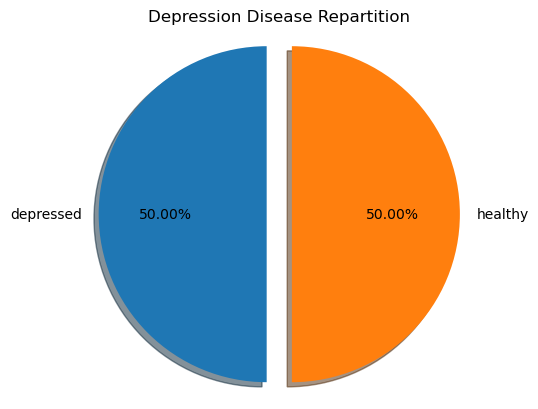

In [19]:
# Labels
labs_names = ['depressed','healthy']
# Target value counts
data_counts = list(bal_df["chronic_medical_conditions"].value_counts())
# Space between pies
pie_space = (0.15, 0)
# Title
plt.title('Depression Disease Repartition')
# Target variable distribution Pie chart
plt.pie(data_counts, explode = pie_space, labels = labs_names , autopct = '%1.2f%%',
        startangle = 90, shadow = True)
# Put title and plot on same axis
plt.axis('equal');

The dataset is now well balanced. If we drop any data during data cleaning. We will proceed to another check to verify wether we can use `accuracy score` as metric to evaluate our models.

## Summary Statistics

In [20]:
# Data description
bal_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,272414.0,48.88,18.17,18.00,33.00,49.00,65.00,80.00
number_of_children,272414.0,1.30,1.24,0.00,0.00,1.00,2.00,4.00
income,272414.0,50205.16,40570.14,0.41,20613.74,37028.01,75477.26,209995.22


There are some outliers in the `income` variable. According to the fact that patient ages vary between `18` to `80` years old, and with real world possibilities, those values, may them be very small (`0.41`), or very large (`209995.22`) are certainly correct values.

However, let's visualize the distribution of numerical variables better to get more information.

## Numerical Data Distribution

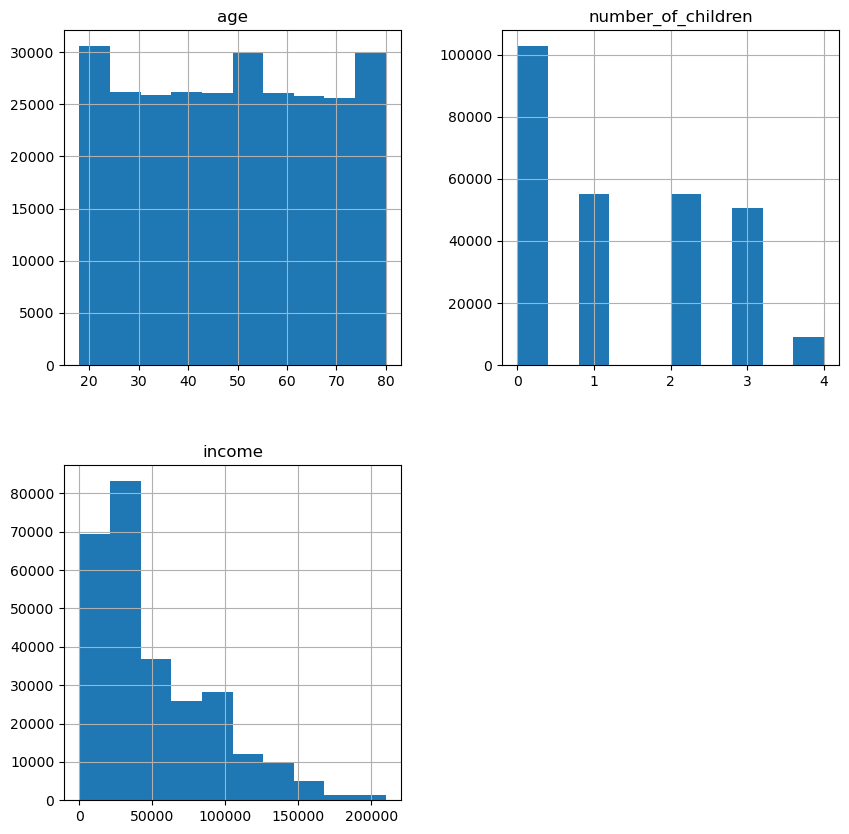

In [21]:
## Histograms of numerical variables
bal_df.hist(figsize = (10, 10));

While the `age` variable follows a quite uniform distribution, the two others are skewed. However, the one that poses more concern is the **income** one as the number of children is an integer from 0 to 4 in our dataset. Let's look at its spread with respect o the disease by using boxplots.

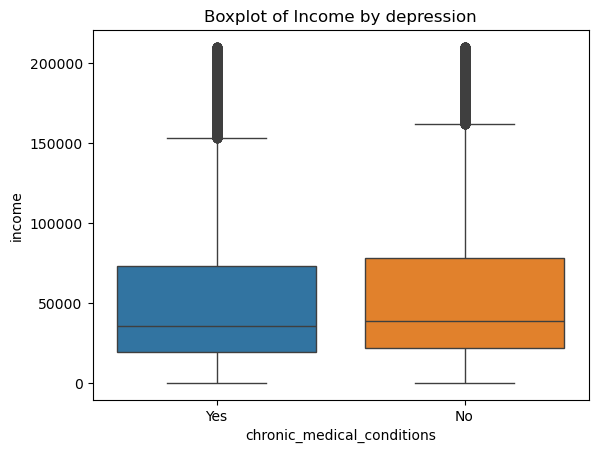

In [22]:
# Boxplot of Income by disease 
sns.boxplot(data = bal_df,
            x = "chronic_medical_conditions", y = "income",
            hue = "chronic_medical_conditions")
# Add title
plt.title("Boxplot of Income by depression");

In our dataset, there seems to be a certain relationship between the disease and patient incomes. It's a light difference, but it seems like the more patients have money, the less the seem to be depressed. We can also see a lot of outliers in both sick and healthy people. We know our dataset is huge. So, let's reduce these outliers. A rule of removing outliers involves excluding data points below the 10th percentile and above the 90th percentile. As we have a big data-set and to reduce computation during model training, we will use this technique.

In [23]:
# Get 10th (low) and 90th (high) percentile
low, high = bal_df["income"].quantile([0.1, 0.9])
# Remove outliers by income
bal_df = bal_df[bal_df["income"].between(low, high)]
# Number of observations after dropping outliers
print(f"Data Size: {len(bal_df)} observations.")

Data Size: 217930 observations.


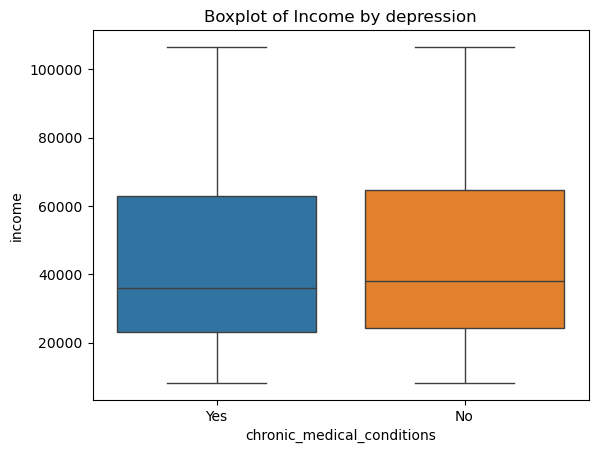

In [24]:
# Boxplot of Income by disease after removing outliers
sns.boxplot(data = bal_df,
            x = "chronic_medical_conditions", y = "income",
            hue = "chronic_medical_conditions")
# Add title
plt.title("Boxplot of Income by depression");

We can see that we do not have outliers anymore. However as expected, the **data remain skew** (*median lines are still in the lower side of the boxes*). Removing outliers did not change the distribution of income. To make our income data more normal so the models we will train, will process them better we will do some **feature engineering**. In fact, for highly skewed features (especially right-skewed as our case), applying a **log transformation** can help models to learn better from the data. We will use the $log(x+1)$ function as $log(x)$ doesn't give any value for $0$ input.

In [25]:
# Income feature engineering
bal_df["log_income"] = np.log1p(bal_df.income)

# Delete the previous income variable
del bal_df["income"]

In [26]:
# list of categorical feature variables
numerical = bal_df.select_dtypes("number").columns.to_list()
numerical

['age', 'number_of_children', 'log_income']

The variable has been replaced. We can look at the distribution of the new one.

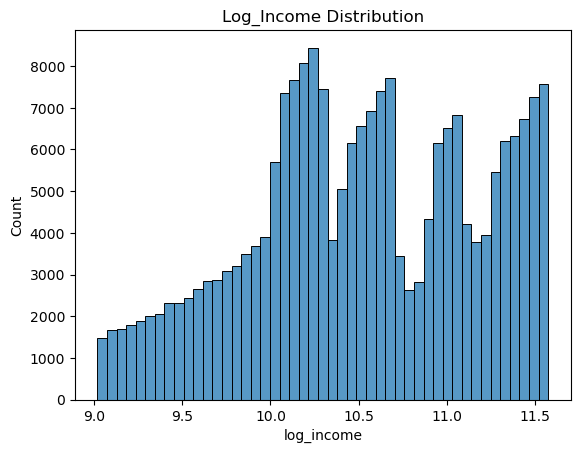

In [27]:
# Income Histogram
sns.histplot(bal_df.log_income, bins = 47)
# Add title
plt.title("Log_Income Distribution");

The skew of the data has drastically changed. To a certain extent, the new variable seem more normal. Another good news is that values have been sshrinked to lower one. So, it won't create a biars compared to other variables, when models are trained, especially when training neural networks for example, if one decide to.

## Multicollinearity check

For good practice, let's take a look at numerical columns to check for multicollinearity.

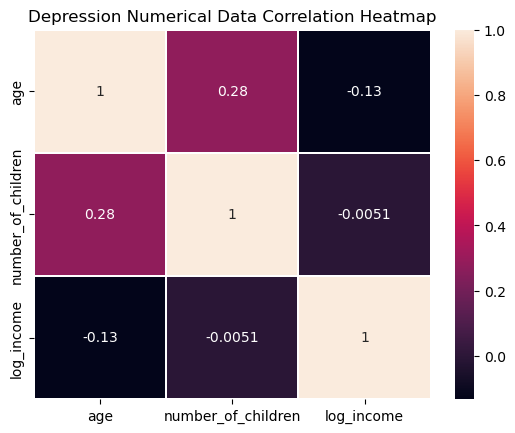

In [28]:
# Correlation Heatmap
plt.title("Depression Numerical Data Correlation Heatmap")
sns.heatmap(bal_df[numerical].corr(), annot = True, linewidths = .1);

The correlation between numerical features is quite low. Even though, this indicate that we don't have to worry about multicollinearity, let's visualize a pairplot of the data.

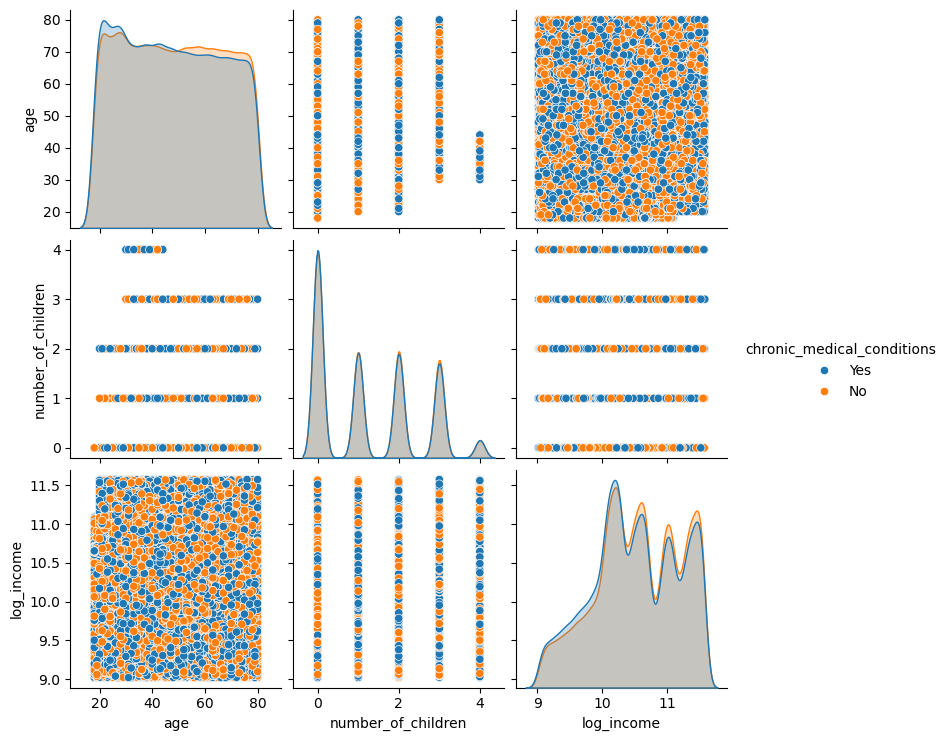

In [29]:
# Pairplot for numerical variables by depression
sns.pairplot(bal_df, hue = "chronic_medical_conditions");

The pairplot doesn't show problematic relationships between numerical features, confirming our earlier thoughts.

## Categorical Features values

In [30]:
# list of categorical feature variables
categorical = bal_df.drop(columns = "chronic_medical_conditions").select_dtypes("object").columns.to_list()
categorical

['marital_status',
 'education_level',
 'smoking_status',
 'physical_activity_level',
 'employment_status',
 'alcohol_consumption',
 'dietary_habits',
 'sleep_patterns',
 'history_of_mental_illness',
 'history_of_substance_abuse',
 'family_history_of_depression']

Let's now visualize the number of distinct values and these values for each variable. This can help to decide to drop low cardinality variables (with only one value) and high cardinality variables (with too much values) in our dataset.

In [31]:
# For each categorical variable
for cat in categorical:
    # Print the variable and its values
    print(f"- {cat}: {bal_df[cat].nunique()} values --> {bal_df[cat].unique()} \n")

- marital_status: 4 values --> ['Single' 'Married' 'Divorced' 'Widowed'] 

- education_level: 5 values --> ['Associate Degree' "Master's Degree" "Bachelor's Degree" 'High School'
 'PhD'] 

- smoking_status: 3 values --> ['Current' 'Non-smoker' 'Former'] 

- physical_activity_level: 3 values --> ['Moderate' 'Sedentary' 'Active'] 

- employment_status: 2 values --> ['Employed' 'Unemployed'] 

- alcohol_consumption: 3 values --> ['High' 'Moderate' 'Low'] 

- dietary_habits: 3 values --> ['Unhealthy' 'Moderate' 'Healthy'] 

- sleep_patterns: 3 values --> ['Poor' 'Fair' 'Good'] 

- history_of_mental_illness: 2 values --> ['Yes' 'No'] 

- history_of_substance_abuse: 2 values --> ['No' 'Yes'] 

- family_history_of_depression: 2 values --> ['No' 'Yes'] 



We do not have any variable with only one distinct value. There is no variable with a high cardinality too. In fact the data is clean with the same values as the ones provided by the Features description section.

What can do now is normalize all those strings with lower-case normalisation, by removing quotes and replacing spaces.

In [32]:
# For each categorical variable
for cat in categorical:
    # Format string values
    bal_df[cat] = (bal_df[cat].
                   str.lower().
                   str.replace(" ", "_").
                   str.replace("'", "").
                   str.replace("-", "_"))

In [33]:
# For each categorical variable
for cat in categorical:
    # Print the variable and its values
    print(f"- {cat}: {bal_df[cat].nunique()} values --> {bal_df[cat].unique()} \n")

- marital_status: 4 values --> ['single' 'married' 'divorced' 'widowed'] 

- education_level: 5 values --> ['associate_degree' 'masters_degree' 'bachelors_degree' 'high_school'
 'phd'] 

- smoking_status: 3 values --> ['current' 'non_smoker' 'former'] 

- physical_activity_level: 3 values --> ['moderate' 'sedentary' 'active'] 

- employment_status: 2 values --> ['employed' 'unemployed'] 

- alcohol_consumption: 3 values --> ['high' 'moderate' 'low'] 

- dietary_habits: 3 values --> ['unhealthy' 'moderate' 'healthy'] 

- sleep_patterns: 3 values --> ['poor' 'fair' 'good'] 

- history_of_mental_illness: 2 values --> ['yes' 'no'] 

- history_of_substance_abuse: 2 values --> ['no' 'yes'] 

- family_history_of_depression: 2 values --> ['no' 'yes'] 



All string values of categorical variables have now been uniformized.

## Target Variable encoding

Machine understand number not text. So, let's encode the target variable:

In [34]:
# Target encoding
bal_df["chronic_medical_conditions"] = (bal_df["chronic_medical_conditions"] == "Yes").astype(int)

As we are about to split the data, it is important to make sure that the data cleaning did not unbalanced it.

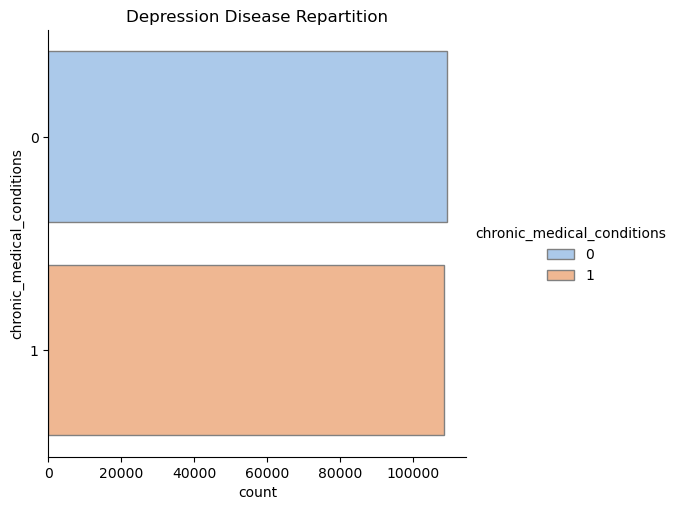

In [35]:
# Target variable distribution
sns.catplot(bal_df, y = "chronic_medical_conditions", kind = "count",
            hue = "chronic_medical_conditions",
            palette = "pastel",
            edgecolor = ".5")
# Title
plt.title('Depression Disease Repartition');

The dataset is well balanced. We can proceed to data splittiing.

## Data Splitting into Train - Validation - Test

We will split the data into Train/validation/test sets with 60%/20%/20% distribution using Scikit-Learn (`train_test_split` function) with a seed of `42`:

In [36]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(bal_df, test_size = 0.2, random_state = 42)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [37]:
# Check datasets sizes after splitting
len(df_train), len(df_val), len(df_test)

(130758, 43586, 43586)

In [38]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

Let's extract the target variable `y` from our dataframes:

In [39]:
# Get the target values
y_train = df_train.chronic_medical_conditions.values
y_test = df_test.chronic_medical_conditions.values
y_val = df_val.chronic_medical_conditions.values

# Drop the target from our data sets
del df_train["chronic_medical_conditions"]
del df_test["chronic_medical_conditions"]
del df_val["chronic_medical_conditions"]

## Feature Importance Analysis

To evaluate feature importance, we can use the **mutual information score** for categorical variables, and the **pearson correlation** for numerical ones.

### Mutual Information

We calculate the mutual information scores (rounded to 2 decimals) between `y` and other categorical variables in the dataset, using the full train data set. We will define a function to ease the process.

In [40]:
# Function to get mutual information sore with respect to the churn
def mutual_info_y_score(series):
    """
    This function takes a series and returns the mutual information score
    with respect to the `y` variable of the full train data set.
    """
    return round(mutual_info_score(series, df_full_train.chronic_medical_conditions), 2)

Now, we can apply this function to the categorical variables:

In [41]:
# Apply mutual information columnwise to categorical variables
mi_scores = df_full_train[categorical].apply(mutual_info_y_score)

# Sourt scores in ascending order
mi_scores.sort_values(ascending = False)

marital_status                  0.0
education_level                 0.0
smoking_status                  0.0
physical_activity_level         0.0
employment_status               0.0
alcohol_consumption             0.0
dietary_habits                  0.0
sleep_patterns                  0.0
history_of_mental_illness       0.0
history_of_substance_abuse      0.0
family_history_of_depression    0.0
dtype: float64

The analysis of the mutual information scores between categorical features and the target variable revealed surprisingly low values 📊. This suggests weak relationships between variables and the target, not to say inexistant which will result in models performing close to a random classifier 🎲.

This outcome is likely due to the synthetic nature of the dataset. Unlike real-world data 🌍, synthetic datasets are artificially generated using algorithms. These algorithms often fail to replicate the complex, non-linear dependencies seen in real-world phenomena, making it difficult for machine learning models to learn meaningful patterns.

### Pearson Correlation

We calculate the mutual information scores (rounded to 2 decimals) between `y` and numerical variables in the dataset, using the full train data set:

In [42]:
# Absolute correlations between numerical columns and target
df_full_train[numerical].corrwith(df_full_train.chronic_medical_conditions).abs().sort_values(ascending = False)

log_income            0.034548
age                   0.018443
number_of_children    0.007529
dtype: float64

The most important numerical variabe is `log_income`, the transformation of the `income` variable of the riginal dataset. However the observation is the same, numerical features too, have a very weak predictive poser in thois dataset.

### **Understanding the Impact of Synthetic Data on Model Performance** 🤖📉  

Models trained on synthetic data are inherently limited by the quality of the dataset. If the synthetic data fails to capture meaningful or realistic relationships, the models will struggle to generalize or make accurate predictions 🚫. This explains why, in this case, the data showonly a weak predictive ower etween features and target variables.

**Reminder** 📢✨  

This project is for **educational and experimental purposes only** 🎓🧪. It is part of my journey to complete the **Machine Learning Zoomcamp** certification 🏅.  

---

**More Sources about Synthetic Data** 📚✨  
- 🤖 **Synthetic Data Generation: What Is It and How Can It Be Used?** - [AI Multiple](https://research.aimultiple.com/synthetic-data/?utm_source=chatgpt.com)   
- 🔍 **The Role of Mutual Information in Machine Learning** - [KDnuggets](https://www.kdnuggets.com/2020/09/mutual-information-feature-selection.html?utm_source=chatgpt.com)  

---

## One-hot Encoding

Before training Machine Learning models, as they only understand numbers, we will encode all categorical variables in our datasets with `One-Hot-Encoding`. For this purpose, we will use `Scikit-Learn` vectorizer: `DictVectorizer`.

In [43]:
# Convert training set to list of dictionaries
train_dicts = df_train.to_dict(orient = 'records')

# Initialize One-Hot-Encoder (vectorizer)
One_Hot_encoder = DictVectorizer(sparse = True) # sparse when there are many categorical variables ---> most of them are 0s
# One-Hot-Encoder training and train data encoding
X_train = One_Hot_encoder.fit_transform(train_dicts)

In [44]:
# Convert validation set to list of dictionaries
val_dicts = df_val.to_dict(orient = 'records')

# Validation data One-Hot-Encoding
X_val = One_Hot_encoder.transform(val_dicts)

In [45]:
# Convert test set to list of dictionaries
test_dicts = df_test.to_dict(orient = 'records')

# Test data One-Hot-Encoding
X_test = One_Hot_encoder.transform(test_dicts)

In [46]:
# Check the features
One_Hot_encoder.get_feature_names_out()

array(['age', 'alcohol_consumption=high', 'alcohol_consumption=low',
       'alcohol_consumption=moderate', 'dietary_habits=healthy',
       'dietary_habits=moderate', 'dietary_habits=unhealthy',
       'education_level=associate_degree',
       'education_level=bachelors_degree', 'education_level=high_school',
       'education_level=masters_degree', 'education_level=phd',
       'employment_status=employed', 'employment_status=unemployed',
       'family_history_of_depression=no',
       'family_history_of_depression=yes', 'history_of_mental_illness=no',
       'history_of_mental_illness=yes', 'history_of_substance_abuse=no',
       'history_of_substance_abuse=yes', 'log_income',
       'marital_status=divorced', 'marital_status=married',
       'marital_status=single', 'marital_status=widowed',
       'number_of_children', 'physical_activity_level=active',
       'physical_activity_level=moderate',
       'physical_activity_level=sedentary', 'sleep_patterns=fair',
       'sleep_patt

# Models Training and Fine Tuning

Our goal is to determine the risk or probability of heart disease, using patient data in order to know if the patient is actually sick or not. This problem is a classification problem with patient information as features and health status as outcome.

To accurately classify data, we will fine tune logistic regression models and decision trees and select the best model for our use case. Note that as the data is huge we could not implement other models.

## Logistic Regression

We will fine tune our logistic regression model on all the features by searching the best regularization parameter `C` among the list: `[0.01, 0.1, 1, 10, 100]`. The accuracy will be calculated on the validation dataset and rounded to 3 decimal digits.

In [47]:
# Parameter list
reg_params = [0.01, 0.1, 1, 2, 10, 100]

# Initialize scores
reg_params_scores = []

# Parameter Fine-Tuning
for param in reg_params:
    # Define the model
    model = LogisticRegression(solver = 'liblinear', C = param,
                               max_iter = 1000, random_state = 42)
    # Model fitting
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)    
    # Accuracy score
    param_score = 100 * (y_pred == y_val).mean()

    # Append rounded score
    reg_params_scores += [round(param_score, 2)]

# Series for parameters scores
param_scores = pd.Series(reg_params_scores, index = reg_params, name = "parameters_scores")
param_scores

0.01      54.07
0.10      54.07
1.00      54.07
2.00      54.07
10.00     54.07
100.00    54.07
Name: parameters_scores, dtype: float64

The best value for the regularization parameter is `0.01` (as it is the smaller) leading to a `logistic regression model` with an accuracy of $54.07 \%$.

## Decision Tree Classifier

As parameters for a decision tree, `max_depth` and `min_samples_leaf` have a greater importance than the others. The first limits the tree's complexity, preventing it from growing too deep and memorizing the training data. The second ensures that leaf nodes have a sufficient number of samples, reducing the chance of creating nodes that are too specific to the training data. That's why we will focus on fine tuning only these two parameters.

First, we will fine tune the `max_depth`, to get a subset of depths values that we will combine with `min_samples_leaf` for another fine-tuning.

<p style = "color:brown">Reminder:</p>
The depth of a tree is the length of the longest path from the root node to a leaf node (terminal node, at the last level of a tree).

In [48]:
# List of potential maximum depths
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, None]

# Decision Tree model fine-tuning with maximum depth
for depth in depths: 
    # Initialize the model with a max_depth
    dt = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    # Model Training
    dt.fit(X_train, y_train)

    # Make predictions
    y_pred = dt.predict(X_val)
    # accuracy score
    acc = 100 * (y_pred == y_val).mean()
    
    print('Maximum depth: %4s -> Accuracy score: %.3f' % (depth, acc))

Maximum depth:    1 -> Accuracy score: 52.120
Maximum depth:    2 -> Accuracy score: 53.692
Maximum depth:    3 -> Accuracy score: 54.527
Maximum depth:    4 -> Accuracy score: 54.531
Maximum depth:    5 -> Accuracy score: 54.421
Maximum depth:    6 -> Accuracy score: 54.483
Maximum depth:    7 -> Accuracy score: 54.380
Maximum depth:    8 -> Accuracy score: 54.235
Maximum depth:    9 -> Accuracy score: 54.137
Maximum depth:   10 -> Accuracy score: 54.047
Maximum depth:   15 -> Accuracy score: 53.322
Maximum depth:   20 -> Accuracy score: 52.164
Maximum depth:   25 -> Accuracy score: 51.400
Maximum depth: None -> Accuracy score: 50.186


According to this model fine-tuning, the best parameter for the tree's maximum depth is between 3 and 6. We can now proceed to another fine-tuning considering those values.

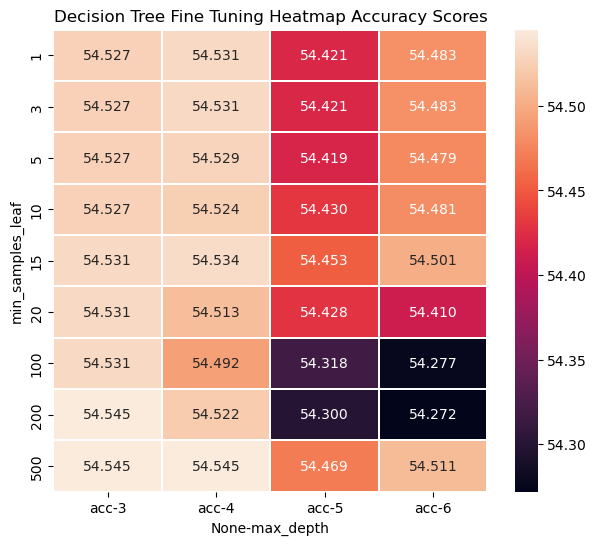

In [49]:
# Initialize scores
scores = []

# Decision Tree fine-tuning with maximum-depth
for depth in [3, 4, 5, 6]:
    # Decision Tree model fine-tuning with minimum samples per leaf
    for s in [1, 3, 5, 10, 15, 20, 100, 200, 500]:
        # Initialize the model with a max_depth and min_samples_leaf
        dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = s, random_state = 42)
        # Model training
        dt.fit(X_train, y_train)

        # Make predictions
        y_pred = dt.predict(X_val)
        # accuracy score
        acc = 100 * (y_pred == y_val).mean()

        # Store parameters and score
        scores.append((depth, s, acc))

# Columns names
columns = ['max_depth', 'min_samples_leaf', 'acc']
# Create dataframe
df_scores = pd.DataFrame(scores, columns = columns)

# Pivot table
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns = ['max_depth'], values = ['acc'])

# Scores Heatmap
plt.figure(figsize = (7, 6))
plt.title("Decision Tree Fine Tuning Heatmap Accuracy Scores")
sns.heatmap(df_scores_pivot, annot = True, fmt = ".3f", linewidths = .1);

**Heatmaps** are useful to visualize lower and higher numerical values faster, and in this particular case, it helps to identify the best parameters: `3` for the `max_depth` and `500` for the `min_samples_leaf`. The optimal decision tree gives an accuracy of $54.545\%$.

# Model Selection

The best model after training and fine tuning logistic regression and decision tree  classifiers, is the **decision tree model** that achieved an accuracy of $54.545 \%$. This final score is very low because of the bad quality of the dataset generated.

# Model Deployment

We will train our model using the `K-Fold Cross-Validation` to evaluate its **stability**. After that, we will train it again on the full train set, and evaluate it on the test set, for saving it using `pickle`.

Let's first define functions for training the model and evaluating it.

In [50]:
# Function for training a random forest classifier
def train(df_train, y_train, max_depth = 3, min_samples_leaf = 500):
    """
    This function takes in a training data set, and its target variable, with hyperparameters
    of a decision tree classifier and trains the model, to return the encoder
    and the classifier trained.
    ---
    df_train: Training data set
    y_train: Training target variable
    max_depth: Maximum depth of decision tree classifier,
                    default: 3
    min_samples_leaf: Minimum sample leaves for decision tree classifier,
                    default: 500
    """
    # Convert training set to list of dictionaries
    train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    # Initialize One-Hot-Encoder (vectorizer)
    One_Hot_encoder = DictVectorizer(sparse = True)
    # One-Hot-Encoder training and train data encoding
    X_train = One_Hot_encoder.fit_transform(train_dicts)

    # Initialize decision tree model
    dt = DecisionTreeClassifier(max_depth = max_depth,
                                min_samples_leaf = min_samples_leaf,
                                random_state = 42)
    
    # Model training
    dt.fit(X_train, y_train)

    # return one-hot-encoder and decision tree model
    return One_Hot_encoder, dt


# Function to make predictions with a random forest classifier
def predict(df, One_Hot_encoder, dt):
    """
    This function takes in a dataframe, a One-Hot-Encoder (dict vectorizer), and
    a decision tree model already trained in order to make predictions.
    ---
    df: dataframe to evaluate the model
    One_Hot_Encoder: dict vectorixer to encode categorical variables in the test dataframe
    rf: decision tree classifier already trained
    """
     # Convert data to list of dictionaries
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    # One-Hot-Encoding
    X = One_Hot_encoder.transform(dicts)
    # Make predictions
    y_pred = dt.predict(X)
    
    # return predictions
    return y_pred

## Cross - Validation Training

Before training our model for the last time, we validate it using the `K-Fold Cross-Validation` method to get a more reliable estimate of its performance, capturing both accuracy's mean and standard deviation.

In [51]:
# Number of splits for Kfold Cross-Validation
n_splits = 5

In [52]:
# Cross Validattion
print(f"Performing KFold Cross-Validation")
# Kfold cross-validation initalization
kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

# Initialize scores
scores = []

# Initialize number of folds
fold = 0

# For each iteration of K-fold split and the pair of indexes generated
for train_idx, val_idx in kfold.split(df_full_train):
    # Select train and validation data
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # Select target variables
    y_train = df_train.chronic_medical_conditions.values
    y_val = df_val.chronic_medical_conditions.values

    # Train model
    One_Hot_encoder, dt = train(df_train, y_train)
    # Make predictions
    y_pred = predict(df_val, One_Hot_encoder, dt)

    # Get score
    acc = round(100 * (y_pred == y_val).mean(), 2)
    # Store score
    scores.append(acc)
    # print auc
    print(f"Accuracy on fold {fold} is {acc} %.")

    # Increment number of fold
    fold += 1
    
# Print scores' means and standard deviations
print("Validation results:")
print('acc mean = %.2f, acc std = +- %.2f' % (np.mean(scores), np.std(scores)))

Performing KFold Cross-Validation
Accuracy on fold 0 is 54.35 %.
Accuracy on fold 1 is 54.57 %.
Accuracy on fold 2 is 54.46 %.
Accuracy on fold 3 is 54.31 %.
Accuracy on fold 4 is 54.83 %.
Validation results:
acc mean = 54.50, acc std = +- 0.19


The accuracy of our model with `K-Fold Cross-Validation` is only slightly different from the previous one. This is good news, especially as the standard deviation of scores is only of $0.19 \%$ for this achieved accuracy of $54.50 \%$.

## Final Model Training

Let's now train our model on the full training data set, and evaluate it on the test set.

In [53]:
# Optimal parameters values
max_depth, min_samples_leaf = 3, 500
# Optimal decision tree model training
One_Hot_encoder, dt = train(df_full_train[categorical + numerical], df_full_train.chronic_medical_conditions,
                            max_depth = max_depth, min_samples_leaf = min_samples_leaf)
# Make predictions
y_pred = predict(df_test, One_Hot_encoder, dt)
# accuracy score
print('Optimal model accuracy = %.2f.' % (100 * (y_pred == y_test).mean()))

Optimal model accuracy = 54.62.


The obtained accuracy of $54.62\%$ is our best one till now.

## Save the model

Let's save our model and the encoder used to a file.

In [54]:
# model file name
output_file = f'dt_model_depth_{max_depth}_min_samples_leaf_{min_samples_leaf}.bin'
output_file

'dt_model_depth_3_min_samples_leaf_500.bin'

In [55]:
# Open file and write into it
with open(output_file, 'wb') as f_out: 
    # Save model
    print("Storing the model into a file:")
    pickle.dump((One_Hot_encoder, dt), f_out)
    
print(f"The model is saved to {output_file}.")

Storing the model into a file:
The model is saved to dt_model_depth_3_min_samples_leaf_500.bin.


In [56]:
# Check files to make sure the model was saved
!ls

LICENSE			   data					      images
README.md		   depression-dataset.zip
capstone_project_01.ipynb  dt_model_depth_3_min_samples_leaf_500.bin


## Load the model

We now load our model to use it.

In [57]:
# Name of the model
input_file = 'dt_model_depth_3_min_samples_leaf_500.bin'

# Open file to read it
with open(input_file, 'rb') as f_in:
    # Load the model
    One_Hot_encoder, dt = pickle.load(f_in)

# output the model
dt

DecisionTreeClassifier(max_depth=3, min_samples_leaf=500, random_state=42)

## Test the model

We enter random information for a patient in order to test the model prediction.

In [58]:
# Random patient information
patient = {'age': 24,
           'marital_status': 'single',
           'education_level': 'masters_degree',
           'number_of_children': 0,
           'smoking_status': 'non_smoker',
           'physical_activity_level': 'moderate',
           'employment_status': 'unemployed',
           'alcohol_consumption': 'low',
           'dietary_habits': 'moderate',
           'sleep_patterns': 'poor',
           'history_of_mental_illness': 'no',
           'history_of_substance_abuse': 'yes',
           'family_history_of_depression': 'yes',
           'log_income': 1.59}

In [59]:
# Format input data
X_i = pd.DataFrame([patient])
# Make predictions
y_i_pred = predict(X_i, One_Hot_encoder, dt)

# Print customer info and the model's prediction
print('input data:')
display(X_i)
print('output information:', y_i_pred)
# Define a treatment if necessary
if y_i_pred[0]:
    print('Define a treatment for the patient-test.')

input data:


,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,log_income
0,24,single,masters_degree,0,non_smoker,moderate,unemployed,low,moderate,poor,no,yes,yes,1.59


output information: [1]
Define a treatment for the patient-test.


---